Text(0.5, 1.0, 'KMeans Clustering of Blobs')

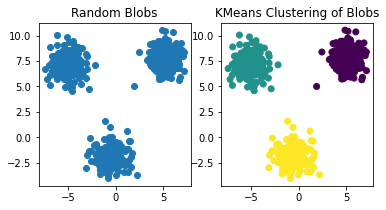

In [146]:
# start of my code
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from matplotlib.patches import Ellipse

n_samples = 500
random_state = 10701
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
plt.figure(figsize=(6,3))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Random Blobs')

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("KMeans Clustering of Blobs")

Text(0.5, 1.0, 'Non-Centroid Blobs GMM')

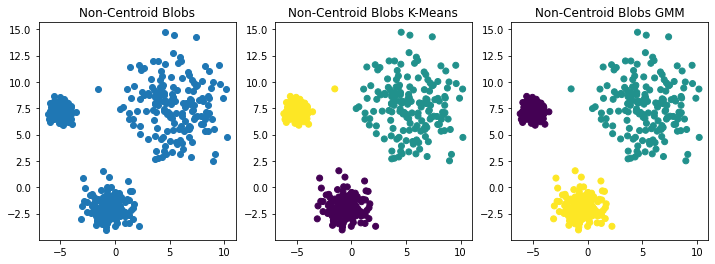

In [147]:
X_noncentroid, y_noncentroid = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_noncentroid)
y_pred_GMM = GaussianMixture(n_components=3).fit_predict(X_noncentroid)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1])
plt.title("Non-Centroid Blobs")
plt.subplot(132)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1], c=y_pred)
plt.title("Non-Centroid Blobs K-Means")
plt.subplot(133)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1], c=y_pred_GMM)
plt.title("Non-Centroid Blobs GMM")

In [148]:
# Implementation of GMM 
def initialize_params(X,components=3):
    # use a cheap k-means classifier to warm start the GMM. 
    # ideally the data can be subsampled. n_clustrers = 3 is known
    kmeans = KMeans(n_clusters= components)
    fitted = kmeans.fit(X)
    prediction = kmeans.predict(X)
    # init all means and covars and responsibilities
    d = X.shape[1]
    labels = np.unique(prediction)
    pi = np.zeros(components)
    mu = np.zeros((components, d))
    sigma = np.zeros((components, d, d))

    for i, label in enumerate(labels):
        idx = np.where(prediction == label) 
        # fill in the init guesses of mu from the k-means centers
        pi[i] = len(idx[0]) / X.shape[0]
        mu[i,:] = np.mean(X[idx], axis = 0)
        muDiff = X[idx] - mu[i,:]
        Nk = X[idx].shape[0]
        # fill in the covars from the spreads of the clusters
        sigma[i,:, :] = np.dot(pi[i] * muDiff.T, muDiff) / Nk
        # each class contributes 1/3rd
        pi[i]=1/components
    assert np.sum(pi) == 1    
    return (pi,mu,sigma)


The E step for the k$^{th}$ iteration is:
$$\gamma(z_{nk}) = \dfrac{\pi_k\mathcal{N}(\mathbf{x}_n|\mathbf{\mu}_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}(\mathbf{x}_n|\mathbf{\mu}_j,\mathbf{\Sigma}_j)}$$

In [149]:

def e_step(x, pi,mu,sigma,components=3):
    # E-step assigns responsibilities for each point and is [n_points x n_clusters] float
    r = np.zeros((len(x), components))
    # calculate the numerator of the E step
    for k in range(components):
        r[:,k] = pi[k]*mvn.pdf(x, mu[k], sigma[k])
    # calculate the denominator of the E step
    for k in range(components):   
        r[:,k] /= sum([pi[j]*mvn.pdf(x, mu[j], sigma[j]) for j in range(components)])
    N = np.sum(r, axis=0)
    return r,N


The M step for the k$^{th}$ iteration :

**1. Calculate new means ** $$\mathbf{\mu}_k^{new} = \dfrac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}\mathbf{x}_n) $$
**2. Calculate new covariance matrix ** $$\mathbf{\Sigma}_k^{new} = \dfrac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n - \mathbf{\mu}_k^{new})(\mathbf{x}_n - \mathbf{\mu}_k^{new})^T$$ 
**3. Calculate new class weights ** $$\pi_k^{new} = \dfrac{N_k}{N}$$
Ideally we should keep iterating till the log-likelihood $\ln p(\mathbf{x}|\mathbf{\mu, \Sigma, \pi})$ falls below a threshold or the updates in the $\mathbf{\mu}$ or (and) the covariances $\mathbf{\Sigma}$ fall below a threshold. In this implementation, we just run it for a certain number of steps and do not check for the terminating conditions. 

In [150]:
    

def m_step(x,r,N,components=3):
    # step 1 
    new_mu = np.dot(r.T, X) / np.sum(r, axis = 0)[:,np.newaxis]
    new_sigma = np.zeros((components,x.shape[1],x.shape[1]))

    for c in range(components):
        x = X - new_mu[c, :] 
        
        diag = np.diag(r[:,c])
        x_mu = np.matrix(x)
        diag = np.matrix(diag)
        sigma_c = x.T * diag * x
        a = (sigma_c) / np.sum(r, axis = 0)[:,np.newaxis][c]
        # step 2
        new_sigma[c,:,:]=a
        
    # step 3
    new_pi = np.mean(r,axis=0)
    return (new_pi,new_mu,new_sigma)


For the prdiction step, we generate the membership probability of each point against the learned Gaussian mixture model parameterized by $\mathbf{\pi_i, \mu_i, \Sigma_i} ~\forall i \in ~\{1,2,..., k\}$.
The class predictions are the arguments of the maximum membership probabilities against the cluster indices.

In [151]:

def predict(x,pi,mu,sigma,components=3):
    prob = []
    prob.append([pi[k]*mvn.pdf(X, mu[k], sigma[k]) for k in range(components)])
    labels = np.array(prob)

    labels  = labels.argmax(1)
    # print(labels.shape,'<--- labels')
    return labels



In [152]:
# Plot utils
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

<Figure size 1440x1440 with 0 Axes>

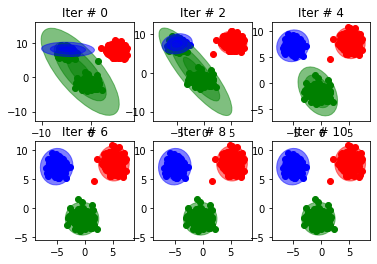

In [161]:
def show_EM(x, iters= 1,components=3):
    # for really use k-means clustering, lower number of GMM iters
    pi,mu,sigma = initialize_params(x) 

    # deleberately poor init
    # pi = np.array([0.33, 0.33, 0.33])
    # mu = np.array([[-5., 5.],[7.5, 15.0],[-5.0, 10]])
    # sigma = np.array([np.eye(2)]*3)
    # for i in range(3):
    #     print(sigma[i,:,:],'<--adad')
    # # print(pi.shape, mu.shape, sigma.shape,'<---')
    # # exit()
    plt.figure(figsize=(20, 20))
    fig, ax = plt.subplots(2,3)
    ax = ax.flatten()
    color = ['green', 'red', 'blue']
    for i in range(iters):
        r,N = e_step(x, pi,mu,sigma)
        pi,mu,sigma = m_step(x,r,N)
        pred = predict(x,pi,mu,sigma)    
        if i%2 == 0:
            for pts in range(x.shape[0]):
                ax[i//2].scatter(X_noncentroid[pts, 0], X_noncentroid[pts, 1], c=color[pred[0][pts]])
            ax[i//2].set_title('Iter # '+str(i))
            for j in range(components):
                draw_ellipse(mu[j], sigma[j], ax = ax[i//2], alpha = 0.5, color = color[j] )
    plt.savefig('fig.png', dpi = 400)
    plt.show()
    return
X_noncentroid, y_noncentroid = make_blobs(n_samples=n_samples, cluster_std=[1.0, 1.1, 0.8], random_state=random_state)
show_EM(X_noncentroid, iters= 12)
